In [1]:
import os
import numpy as np
import nltk
import pandas as pd
import json
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk import word_tokenize
import string
import json
import unidecode 
import re

from preprocessing.preprocessing import Preprocessor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/kian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/kian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
class DataReader:
    def __init__(self, read_from_excels=False):
        if read_from_excels:
            preprocessor = Preprocessor()
            dfs = []
            for file in tqdm(os.listdir("./Excels")):
                df = pd.read_excel(os.path.join("./Excels", file))
                dfs.append(df)
            df = pd.concat(dfs)
            
            df = df[df['Language'] == 'en']
            df.reset_index(drop=True, inplace=True)
            df.drop_duplicates(subset="Text", keep='first', inplace=True, ignore_index=True)
            df = preprocessor.perform_clean_lemmatize_tokenize(df)
            idx = df.Text_words.apply(len) > df.Text_words.apply(len).describe()["25%"]
            df = df[idx]
            
            df["Text_words_joined"] = df.Text_words.apply(lambda x: " ".join(x))
            df.drop_duplicates(subset="Text_words_joined", keep='first', inplace=True, ignore_index=True)
            self.df = df
            
        else:
            df = pd.read_csv("./data_final.csv")
            df["Text_words"] = df.Text_words_joined.apply(lambda x: x.split(" "))
            df.drop("Unnamed: 0", axis=1, inplace=True)
            self.df = df

       
            
data_reader = DataReader(read_from_excels=False)
df = data_reader.df

In [3]:
df.head()

,Tweet Id,Text,cleaned_tweets,lemmatized_tweets,Text_words_joined,Text_words
0,1547201923266351106,RT @JonJonesSnr : Labour accuses No 10 of 'fla...,labour accuses flagrant abuse power refuses al...,labour accuse flagrant abuse power refuse allo...,labour accuse flagrant abuse power refuse allo...,"[labour, accuse, flagrant, abuse, power, refus..."
1,1547201914525421569,@DonaldJTrumpJr Unbelievable. Closing down the...,unbelievable closing debate saying opens trans...,unbelievable close debate say open trans peopl...,unbelievable close debate say open trans peopl...,"[unbelievable, close, debate, say, open, trans..."
2,1547201911853572096,Isn’t it funny how once the internet learned l...,funny internet learned logical fallacy termino...,funny internet learn logical fallacy terminolo...,funny internet learn logical fallacy terminolo...,"[funny, internet, learn, logical, fallacy, ter..."
3,1547201910670823426,"@MoeedNj You're right, Moeed. Political rhetor...",right moeed political rhetoric par excellence ...,right moeed political rhetoric par excellence ...,right moeed political rhetoric par excellence ...,"[right, moeed, political, rhetoric, par, excel..."
4,1547201898884878336,RT @BryanDBender : JUST IN: UFO amnesty provis...,ufo amnesty provision proposed order house rul...,ufo amnesty provision propose order house rule...,ufo amnesty provision propose order house rule...,"[ufo, amnesty, provision, propose, order, hous..."


In [4]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

class TransformerEmbedding:
    def __init__(self, df):
        self.all_embeddings = np.load("./transformer_embeddings.npy")

In [5]:
t = TransformerEmbedding(df)

In [6]:
emb = t.all_embeddings

In [90]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="k-means++", n_clusters=10)

kmeans.fit(emb)
y = kmeans.labels_

In [91]:
kmeans.inertia_

20567.048828125

In [92]:
pca = PCA(n_components=2).fit_transform(emb)

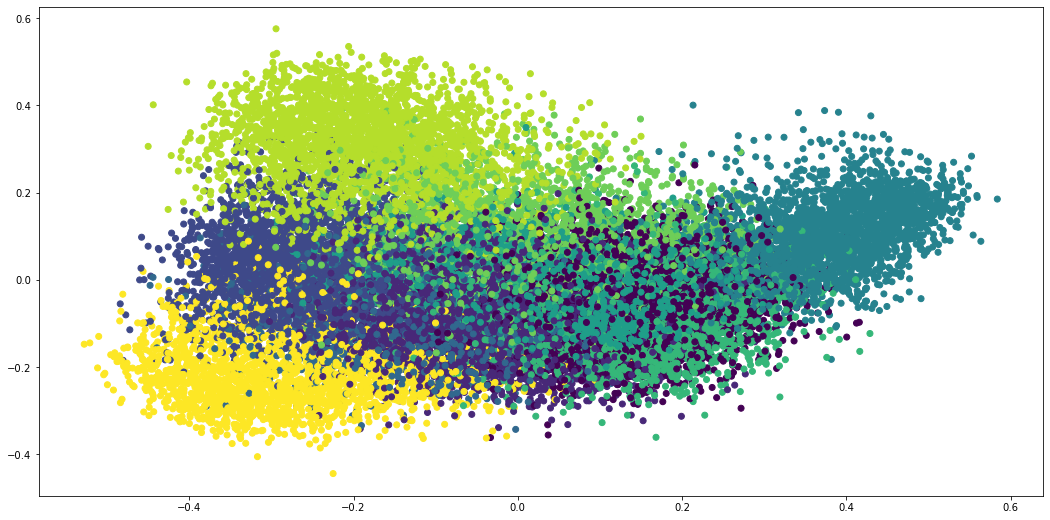

In [93]:
plt.figure(figsize=(18, 9))
plt.scatter(pca[:, 0], pca[:, 1], c=y);

In [98]:
results = pd.DataFrame()
for label in range(10):
    results[f"Cluster{label}"] = df[y == label].Text_words.explode().value_counts().head(15).index
results

,Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5,Cluster6,Cluster7,Cluster8,Cluster9
0,get,book,trump,covid,developer,tesla,learn,inflation,ukraine,abortion
1,new,joe,democrats,vaccine,salary,elon,reality,workers,war,pregnancy
2,apple,like,joe,get,remote,musk,virtual,back,russia,women
3,us,rogan,biden,booster,job,twitter,deep,work,iran,right
4,use,get,say,people,ps,model,robots,get,us,get
5,game,go,get,dose,full,buy,ai,go,russian,people
6,back,one,would,vaccines,location,spot,use,people,say,state
7,macbook,time,people,say,kpa,first,new,pay,biden,say
8,launch,back,go,vaccinate,stack,get,science,office,politics,baby
9,time,make,back,free,new,someone,like,us,putin,us
